#Sentiment Classifier using Recurrent NNs

The goal of this notebook is to develop a sentiment classifier using a bidirectional stacked RNN with LSTM or GRU cells for the Twitter sentiment analysis dataset. We are going to experiment with a plethora of hyperparameters, aiming to find the best possible RNN model, in order to compare it to those of the previous assignments (Simple NNs, LogReg). In order to produce the features for our NN, we are going to used pre-trained word embedings by GloVe, just like in the previous assignment. 

We going to experiment with the following parameters and techniques, which will be analyzed later on:
 - Type of cells (LSTM/GRU)
 - Number of layers of the RNN
 - Skipping connections
 - Clipping gradients
 - Dropout whithin the RNN.

 Also, as a part of the bonus of the assignment, I will introduce an attention layer to the RNN.

 But, first up, let's define our data and preprocess it in order to create a handy input for our RNN.

## Import libraries

In [1]:
!python -m textblob.download_corpora
# For NN models
import torch.nn as nn
import torch
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
# For large and multi-dimensional arrays
import numpy as np
# For basic cleaning and data preprocessing 
import re
# For data manipulation and analysis
import pandas as pd
# Stop words
import nltk 
nltk.download('stopwords')  
# Data manipulation
import torchtext
from torchtext import data
from torchtext.data import Field
import torch.nn.functional as F
# Data Preprocessing and Feature Engineering
from textblob import TextBlob
import scipy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# Necessary for data format
from sklearn.feature_extraction.text import CountVectorizer
# Word embedings
from sklearn.feature_extraction.text import TfidfVectorizer  
# Machine learning model
from sklearn.linear_model import LogisticRegression
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Best parameters during classification
from sklearn.model_selection import GridSearchCV
# Data preprocessing
from sklearn.model_selection import train_test_split
# Validation of the model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset Configuration

We are going to import the dataset...

In [2]:
df = pd.read_csv("/content/drive/MyDrive/tn2/SentimentTweets.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1280000 non-null  int64 
 1   target      1280000 non-null  int64 
 2   id          1280000 non-null  int64 
 3   date        1280000 non-null  object
 4   flag        1280000 non-null  object
 5   user        1280000 non-null  object
 6   text        1280000 non-null  object
dtypes: int64(3), object(4)
memory usage: 68.4+ MB


...and take a look at its columns

In [3]:
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


## Data Preprocessing

Like the other notebook that we made,we have to preprocess our data set. We are going to convert everything to lowercase, and remove any punctuation points, weird characters and links.

We are going to classify tweets. As we all know, twitter users use the symbols `#` and `@` a lot. This may cause problem to the classifier, thus we are going to remove them, using `TextBlob`. We are also going to lemmatize the data in order to avoid multiple representations of the same word

In [4]:
def text_normalization(text):
    # convert text to lowercase
    text = text.lower()
    # remove non alphanumeric character
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    # remove links
    text = re.sub(r'https?:/\/\S+', ' ', text)
   
    return text

In [5]:
def preprocess(input_df):
    # Remove rows with missing values in column col
    input_df.dropna(inplace=True)
    # Speed up code using numpy vectorization
    vfunc = np.vectorize(text_normalization)
    input_df.text = vfunc(input_df.text.values)
    # return processed input_df
    return input_df

Let's now apply those techniques in our dataset.

In [6]:
df = preprocess(df)
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,brokenpromises
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,david carradine so sad thai s law not sure if ...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,a 415 b 425 tell your bro i say congrats
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,littlefluffycat indeed
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,completed race 4 life in 58mins with girlies f...


We are going to convert the target value to 1 instead of 4, in order to be more convenient.

In [7]:
def change_to_1(x):
    if (x == 4):
        return 1
    else:
        return x

In [8]:
df['target'] = df['target'].apply(change_to_1)
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,brokenpromises
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,david carradine so sad thai s law not sure if ...
2,1337108,1,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,a 415 b 425 tell your bro i say congrats
3,1560887,1,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,littlefluffycat indeed
4,1466295,1,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,completed race 4 life in 58mins with girlies f...


We are now going to drop the columns we do not need, in order to save memory

In [9]:
df = df.drop(['Unnamed: 0', 'id', 'date', 'flag', 'user'], axis=1)

### Splitting the dataset

We are now going to split the dataset in order to have a dataset for training, one for validating, and one for testing our models

In [10]:
train_df, valid_df = train_test_split(df, train_size = .9, random_state = 42)
test_df, train_df = train_test_split(df, train_size = .1, random_state = 42)

train_df.to_csv('train.csv', index=False)
train_df.to_csv('valid.csv', index=False)
train_df.to_csv('test.csv', index=False)

print(f'Number of training examples: {len(train_df)}')
print(f'Number of validation examples: {len(valid_df)}')
print(f'Number of testing examples: {len(test_df)}')

Number of training examples: 1152000
Number of validation examples: 128000
Number of testing examples: 128000


## Feature extractions: Pre-Trained word vectors using `TorchText`

TorchText provides a handy API that allows as to handle a dataset in a way that PyTorch networks understand, while being able to apply techniques such as loading pretrained vectors, which is the goal of this notebook.

### Definition of dataset processing

We are going to define the columns that we want to process

In [11]:
TEXT = data.Field(tokenize = 'spacy', include_lengths=True)

LABEL = data.LabelField(dtype = torch.float)

# define which fiels we are going to process
train_val_fields = [
  ('text', TEXT), # process it as text
  ('target', LABEL) # process it as label
]

Now, we are going to use the class we created in order to convert our dataset in the appropriate type.

In [12]:
TEXT = data.Field(tokenize = 'spacy', include_lengths=True)
LABEL = data.LabelField(dtype = torch.float)

fields = {'text': ('text', TEXT), 'target': ('target', LABEL)}

train_ds, val_ds, test_ds = data.TabularDataset.splits(path='/content/', train='train.csv', validation='valid.csv', test='test.csv', format='csv', fields=fields)

Let's print an item from the dataset, in order to observe its form

In [13]:
print(vars(train_ds[0]))

{'text': ['no', 'way', 'in', 'all', 'of', 'the', 'craziness', 'of', 'today', 'i', 'forgot', 'that', 'my', 'song', 'quot', 'people', 'quot', 'was', 'played', 'on', 'mtv', 's', 'quot', 'college', 'life', 'quot', 'tonight', 'noooooooo'], 'target': '0'}


### Loading Pre-Trained vector embeddings

Next up, we are going to load the glove vectors in order to build our vocabulary that will be used in our model. We are going to define the maximum vocabulary size, getting the info from the TFIDF notebook, where our vocabulary length was 2000.

For every word that is not int the pretrained vectors' map, we are going to use values that are randomly distributed.

In [14]:
vocab_size = 20000
# build the vocabulary for both of the fields
TEXT.build_vocab(train_ds,  max_size = vocab_size, vectors = 'glove.6B.50d', unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_ds)

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 399411/400000 [00:11<00:00, 37156.26it/s]

Another method to help as achieve our goal faster, is `BucketIterator`, a method that defines an iterator that batches examples of similar lenths together, in roder to minimise the necessary amount of padding during training

In [15]:
# preferebly use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the 2 iterators
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_ds, val_ds, test_ds), 
    batch_size = 128, device = device, sort_within_batch = True, sort_key = lambda x: len(x.text,))

We are now all set in order to define our neural networks that will try to classify the available tweets as negative or positive. We will construct different models, that differ when it comes down to hyperparameters, and then evaluate them so we can conclude which is best.

## Model Definition

We want to experiment with different hyperparameters, and so we must train our network many times. Thus, we will create a class in order to have our model and its parameters in one place. 

In [16]:
NEG_INF = -10000
TINY_FLOAT = 1e-6

def seq_mask(seq_len, max_len):

    idx = torch.arange(max_len).to(seq_len).repeat(seq_len.size(0), 1)
    mask = torch.gt(seq_len.unsqueeze(1), idx).to(seq_len)

    return mask

def mask_softmax(matrix, mask=None):

    if mask is None:
        result = F.softmax(matrix, dim=-1)
    else:
        mask_norm = ((1 - mask) * NEG_INF).to(matrix)
        for i in range(matrix.dim() - mask_norm.dim()):
            mask_norm = mask_norm.unsqueeze(1)
        result = F.softmax(matrix + mask_norm, dim=-1)

    return result

def mask_mean(seq, mask=None):

    if mask is None:
        return torch.mean(seq, dim=1)

    mask_sum = torch.sum(  # [b,msl,nc]->[b,nc]
        seq * mask.unsqueeze(-1).float(), dim=1)
    seq_len = torch.sum(mask, dim=-1)  # [b]
    mask_mean = mask_sum / (seq_len.unsqueeze(-1).float() + TINY_FLOAT)

    return mask_mean


def mask_max(seq, mask=None):

    if mask is None:
        return torch.mean(seq, dim=1)

    torch
    mask_max, _ = torch.max(  # [b,msl,nc]->[b,nc]
        seq + (1 - mask.unsqueeze(-1).float()) * NEG_INF,
        dim=1)

    return mask_max


class Bidirectional_Stacked_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, output_size, num_layers, cell_type, dropout_rate, pad_idx, bidirectional=True, attention=False):
        # initialize the mother class
        super(Bidirectional_Stacked_RNN, self).__init__()

        # create a dict for the possible types of cells
        cells = {
            "RNN"  : nn.RNN, 
            "LSTM" : nn.LSTM,
            "GRU"  : nn.GRU
        }
        # make sure that a compatible cell type is selected
        if (cell_type not in cells):
            print("Wrong cell type selected")
            return
        self.cell_type, self.input_dim ,self.embedding_dim, self.hidden_dim, self.num_layers, self.attention = cell_type, input_dim, embedding_dim, hidden_dim, num_layers, attention

        # embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        # rnn layer
        self.rnn = cells[cell_type](
            input_size = embedding_dim,     # feature size 
            hidden_size = hidden_dim,       # hidden embedding representation
            num_layers = num_layers,        # layers on our stacked RNN 
            bidirectional = bidirectional,  # out NN is bidirectional
            dropout = dropout_rate          # dropout rate in-between the rnn layer
        )


        # dropout layer
        self.dropout = nn.Dropout(dropout)
        if bidirectional == True:

            # if our model is bidirectional, we will have 2 more layers as the output to the final layer
            self.out = nn.Linear(hidden_dim * 2, output_size)
            # attention layer
            self.fc_att = nn.Linear(hidden_dim * 2, output_size)

        else:
            # if our model is not bidirectional
            self.out = nn.Linear(hidden_dim, output_size)
            # attention layer
            self.fc_att = nn.Linear(hidden_dim, output_size)

        # activation using the sigmoid function
        self.activation = nn.Sigmoid()


    def forward(self, x, lengths):
        # create the embedding layer
        embedded = self.dropout(self.embedding(x))
        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=False)


        # LSTM cells reutrn also the last cell states
        if self.cell_type == 'LSTM':
            r_out, (last_hidden_state, last_cell_state) = self.rnn(packed_embedded) 
        else:
            r_out, last_hidden_state = self.rnn(packed_embedded)
            
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(r_out)
        output = output.permute(1,0,2)

        # Concat the forward and backward hidden layers of the output
        hidden = torch.cat((last_hidden_state[-2,:,:], last_hidden_state[-1,:,:]), dim = 1)
     
        if (self.attention == True):
            max_seq_len = torch.max(lengths)
            mask = seq_mask(lengths, max_seq_len)  # [b,msl]
            
            # attention
            att = self.fc_att(output).squeeze(-1)  # [b,msl,h*2]->[b,msl]
            att = mask_softmax(att, mask)  # [b,msl]
            attention_output = torch.sum(att.unsqueeze(-1) * output, dim=1)  # [b,h*2]
            
            # activation, fully connnected and dropout layer all in once   
            return self.activation(self.out(self.dropout(attention_output)))

        else:
            return self.activation(self.out(self.dropout(hidden)))
        




## HyperParameters and techniques explanation

Unlike our previous notebooks, this time we have plenty of hyperparameters to experiment with, all of whom are extremely important to our results. We also have many techniques based on the theory that will help us to achieve better accuracy in our model. The hyperparameters that we will be experimenting with are: 
 - __Cell types__: We have 2 different options of cells, the LSTM and GRU. Both of those cell types are trying to solve the vanishing and exploding gradients problem, and they offer the solution of keeping a long-term memory in our NN. This way, in a big sentence, words that encounter early, will be taken into consideration, somehting that is nearly impossible in simple RNNs. The difference between those cell types, are that GRU cells are simpler, quicker to compute and require fewer parameters. However, a standard practice is to begin with LSTM, and that's how we are going to proceed.

 - __Number of layers__: Like in simple or convolutional NNs, the more layers we have, the more complex the calculations become, and thus we have better results for complicated problems. However, given that sentiment classification is not such a difficult computational task, we would rather use only a few layers(2 or maybe 3). If we are not satisfyied by our results, we are free to increase them.

 - __Dropout__: In order to avoid overfitting, the must cut the connections between some neurons in our NN. A standard approach for this kind of task, is close to 20-30% of the connections to be cut.

 - __Learning rate, epochs__: Allready used and known.

\
Some techniques that favor us in order to achieve better classification:
  - __Bi-directional NNs__: By having such a neural network, we are now able to take into consideration a tweet both forwards, and backwards, so for example the sentence `This was terribly exciting`, will be classified as positive.
  - __Clipping gradients__: A way to avoid the exploding gradients problem.
  - __Skipping connections__: A way to avoid the vanishing gradients problem, which is however used in more deep networks(eg. 8 layers).

Finally, we are going to define a function that we are going to use to determine our models' train accuracy.

In [17]:
def my_accuracy(pred, label):

    #round predictions to the closest integer
    preds = torch.round(pred)
    # find the correct ones
    correct = (preds == label).float()
    # simple accuracy
    acc = correct.sum() / len(correct)
    return acc

## Defining a training and evaluating method

Next up, we are going to define a training method that uses all the previously mentioned parameters and trains a specific model.

In [18]:
def train(model, iterator, optimizer, loss, clipping_rate=(-5,5)):
    # Start train mode
    model.train()

    # hold the results in order to plot them
    epoch_loss = 0
    epoch_acc = 0
    items = 0

    for batch in iterator:
        items += 1
        # get text info
        text, lengths = batch.text
        # clear gradients
        optimizer.zero_grad()
        # forward probagation
        output = model(text, lengths).squeeze(1)

        # compute loss and accuracy and append them in the aprropriate lists
        ret_loss = loss(output, batch.target)
        accuracy = my_accuracy(output, batch.target)

        # pass gradients back, startiing on loss value
        ret_loss.backward()

        # Clip gradients
        for param in model.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, clipping_rate[0], clipping_rate[1])
        # apply gradients
        optimizer.step()

        epoch_loss += ret_loss.item()
        epoch_acc += accuracy.item()

    return epoch_loss / items, epoch_acc / items

In [19]:
def evaluate(model, iterator, loss):
    # hold the results in order to plot them
    epoch_loss = 0
    epoch_acc = 0
    items = 0

    model.eval()
    
    # do not change the gradients
    with torch.no_grad():

        # iterate through our dataset
        for batch in iterator:
            items += 1
            # get text info
            text, len = batch.text

            # get the predictions
            predict = model(text, len).squeeze(1)

            # and compute the metrics
            losses = loss(predict, batch.target)
            acc = my_accuracy(predict, batch.target)

            epoch_loss += losses.item()
            epoch_acc += acc.item()

    return epoch_loss / items, epoch_acc / items


In [20]:
def train_and_eval(model, iterator, valid_iterator, optimizer, loss, epochs, l_rate, pad_idx, clipping_rate=(-5,5)):
    print('Began training for {} trainable parameters\n\n'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

    model = model.to(device)
    loss = loss.to(device)
    
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    unk_idx = TEXT.vocab.stoi[TEXT.unk_token]

    model.embedding.weight.data[unk_idx] = torch.zeros(model.embedding_dim)
    model.embedding.weight.data[pad_idx] = torch.zeros(model.embedding_dim)

    loss_list = []
    acc_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(epochs):
        train_loss, train_acc = train(model, iterator, optimizer, loss, clipping_rate)
        valid_loss, valid_acc = evaluate(model, valid_iterator, loss)

        loss_list.append(train_loss)
        acc_list.append(train_acc)
        val_loss_list.append(valid_loss)
        val_acc_list.append(valid_acc)

        print(f'Epoch: {epoch+1}/{epochs}  | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    return loss_list, acc_list, val_loss_list, val_acc_list

## Experimenting using different Models

Now that we have defined everything regarding to our data and models, it is time to use it, by defining several models, and comparing them in order to decide which combination of hyperparameters is the best. The comparison will be made by observing the results and the plots of the training procedure.

Some of the parameters will be the same during our testings. Those will be:

In [21]:
input_shape = len(TEXT.vocab)
loss = torch.nn.BCELoss()
output_neurons = 1
embedding_neurons = len(TEXT.vocab.vectors[0])
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

We will begin rather conservatively, going by the book and starting with the following parameters:

In [22]:
cell_type = 'LSTM'
layers = 2
dropout = 0.4
learning_rate = 0.001
epochs = 5
hidden_neurons = 50
clipping_rate = (-5,5)

In [23]:
model_1 = Bidirectional_Stacked_RNN(input_shape, hidden_neurons, embedding_neurons, output_neurons, layers, cell_type, dropout, pad_idx)


optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

_, _, _, _ = train_and_eval(model_1, train_iterator, valid_iterator, optimizer, loss, epochs, learning_rate, pad_idx, clipping_rate)

Began training for 1101902 trainable parameters




100%|█████████▉| 399411/400000 [00:29<00:00, 37156.26it/s]

Epoch: 1/5  | Train Loss: 0.452 | Train Acc: 78.64% | Val. Loss: 0.399 |  Val. Acc: 81.82%
Epoch: 2/5  | Train Loss: 0.404 | Train Acc: 81.63% | Val. Loss: 0.372 |  Val. Acc: 83.26%
Epoch: 3/5  | Train Loss: 0.389 | Train Acc: 82.48% | Val. Loss: 0.364 |  Val. Acc: 83.68%
Epoch: 4/5  | Train Loss: 0.380 | Train Acc: 82.95% | Val. Loss: 0.354 |  Val. Acc: 84.28%
Epoch: 5/5  | Train Loss: 0.373 | Train Acc: 83.29% | Val. Loss: 0.347 |  Val. Acc: 84.62%


As we can see, our results are better than our previous models. Let's now try to increase the hidden neurons, while applying less dropout, while making our model bi-directional

In [24]:
cell_type = 'LSTM'
layers = 2
dropout = 0.3
learning_rate = 0.001
epochs = 5
hidden_neurons = 100
clipping_rate = (-5,5)
bidirectional = True

In [25]:
model_2 = Bidirectional_Stacked_RNN(input_shape, hidden_neurons, embedding_neurons, output_neurons, layers, cell_type, dropout, pad_idx, bidirectional)

optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

_, _, _, _ = train_and_eval(model_2, train_iterator, valid_iterator, optimizer, loss, epochs, learning_rate, pad_idx, clipping_rate)

Began training for 1363702 trainable parameters


Epoch: 1/5  | Train Loss: 0.438 | Train Acc: 79.46% | Val. Loss: 0.387 |  Val. Acc: 82.40%
Epoch: 2/5  | Train Loss: 0.390 | Train Acc: 82.35% | Val. Loss: 0.361 |  Val. Acc: 83.93%
Epoch: 3/5  | Train Loss: 0.374 | Train Acc: 83.22% | Val. Loss: 0.347 |  Val. Acc: 84.64%
Epoch: 4/5  | Train Loss: 0.364 | Train Acc: 83.77% | Val. Loss: 0.336 |  Val. Acc: 85.15%
Epoch: 5/5  | Train Loss: 0.356 | Train Acc: 84.21% | Val. Loss: 0.328 |  Val. Acc: 85.58%


We observe that  the results are even better. Let's now try to increase the learning rate, in order to possibly fix the large difference between the training and the validation accuracy.

In [26]:
cell_type = 'LSTM'
layers = 2
dropout = 0.6
learning_rate = 0.01
epochs = 5
hidden_neurons = 100
clipping_rate = (-5,5)
bidirectional = True

In [27]:
model_2 = Bidirectional_Stacked_RNN(input_shape, hidden_neurons, embedding_neurons, output_neurons, layers, cell_type, dropout, pad_idx, bidirectional)

optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

_, _, _, _ = train_and_eval(model_2, train_iterator, valid_iterator, optimizer, loss, epochs, learning_rate, pad_idx, clipping_rate)

Began training for 1363702 trainable parameters


Epoch: 1/5  | Train Loss: 0.479 | Train Acc: 77.48% | Val. Loss: 0.442 |  Val. Acc: 80.20%
Epoch: 2/5  | Train Loss: 0.483 | Train Acc: 77.22% | Val. Loss: 0.452 |  Val. Acc: 79.56%
Epoch: 3/5  | Train Loss: 0.501 | Train Acc: 76.02% | Val. Loss: 0.450 |  Val. Acc: 79.14%
Epoch: 4/5  | Train Loss: 0.520 | Train Acc: 74.70% | Val. Loss: 0.463 |  Val. Acc: 78.53%
Epoch: 5/5  | Train Loss: 0.546 | Train Acc: 72.78% | Val. Loss: 0.471 |  Val. Acc: 77.81%


We are now going to experiment with a different type of cells: GRU, which are said to be faster and with better results. The expirement with the higher learning rate did not go well, thus we are going to decrease it again.

In [28]:
cell_type = 'GRU'
layers = 2
dropout = 0.6
learning_rate = 0.001
epochs = 5
hidden_neurons = 100
clipping_rate = (-5,5)
bidirectional = True

In [29]:
model_3 = Bidirectional_Stacked_RNN(input_shape, hidden_neurons, embedding_neurons, output_neurons, layers, cell_type, dropout, pad_idx, bidirectional)

optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

_, _, _, _ = train_and_eval(model_3, train_iterator, valid_iterator, optimizer, loss, epochs, learning_rate, pad_idx, clipping_rate)

Began training for 1272902 trainable parameters


Epoch: 1/5  | Train Loss: 0.476 | Train Acc: 77.12% | Val. Loss: 0.408 |  Val. Acc: 81.43%
Epoch: 2/5  | Train Loss: 0.424 | Train Acc: 80.46% | Val. Loss: 0.384 |  Val. Acc: 82.71%
Epoch: 3/5  | Train Loss: 0.409 | Train Acc: 81.35% | Val. Loss: 0.380 |  Val. Acc: 83.11%
Epoch: 4/5  | Train Loss: 0.401 | Train Acc: 81.82% | Val. Loss: 0.370 |  Val. Acc: 83.50%
Epoch: 5/5  | Train Loss: 0.395 | Train Acc: 82.16% | Val. Loss: 0.367 |  Val. Acc: 83.65%


Compared to the similar model with the LSTM cells, we get better numbers with the GRU ones. Thus, we are going to proceed the search for our best model, using GRU cells.

Let's now make our models more complex, by adding layers and hidden neurons, and see whether that results into overfitting or not.

In [30]:
cell_type = 'GRU'
layers = 3
dropout = 0.5
learning_rate = 0.001
epochs = 5
hidden_neurons = 200
clipping_rate = (-5,5)
bidirectional = True

In [31]:
model_4 = Bidirectional_Stacked_RNN(input_shape, hidden_neurons, embedding_neurons, output_neurons, layers, cell_type, dropout, pad_idx, bidirectional)

optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

_, _, _, _ = train_and_eval(model_4, train_iterator, valid_iterator, optimizer, loss, epochs, learning_rate, pad_idx, clipping_rate)

Began training for 2748102 trainable parameters


Epoch: 1/5  | Train Loss: 0.461 | Train Acc: 78.11% | Val. Loss: 0.396 |  Val. Acc: 81.87%
Epoch: 2/5  | Train Loss: 0.410 | Train Acc: 81.30% | Val. Loss: 0.373 |  Val. Acc: 83.24%
Epoch: 3/5  | Train Loss: 0.396 | Train Acc: 82.10% | Val. Loss: 0.365 |  Val. Acc: 83.68%
Epoch: 4/5  | Train Loss: 0.388 | Train Acc: 82.53% | Val. Loss: 0.361 |  Val. Acc: 83.90%
Epoch: 5/5  | Train Loss: 0.383 | Train Acc: 82.82% | Val. Loss: 0.356 |  Val. Acc: 84.15%


Our model did not overfit, although it took significant time to train, even with 5 epochs. Thus, we are not going to proceed with 3 layers, because it makes our model nuch more complex, without adding significant accuracy. We are going to hold on to 200 neurons, but we are going to increase the clipping rate, in order to observe the results. We are also going to decrease the dropout rate. 

In [32]:
cell_type = 'GRU'
layers = 2
dropout = 0.5
learning_rate = 0.001
epochs = 5
hidden_neurons = 200
clipping_rate = (-100,100)
bidirectional = True

In [33]:
model_5 = Bidirectional_Stacked_RNN(input_shape, hidden_neurons, embedding_neurons, output_neurons, layers, cell_type, dropout, pad_idx, bidirectional)

optimizer = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

_, _, _, _ = train_and_eval(model_5, train_iterator, valid_iterator, optimizer, loss, epochs, learning_rate, pad_idx, clipping_rate)

Began training for 2025702 trainable parameters


Epoch: 1/5  | Train Loss: 0.459 | Train Acc: 78.18% | Val. Loss: 0.391 |  Val. Acc: 82.34%
Epoch: 2/5  | Train Loss: 0.409 | Train Acc: 81.29% | Val. Loss: 0.372 |  Val. Acc: 83.29%
Epoch: 3/5  | Train Loss: 0.395 | Train Acc: 82.11% | Val. Loss: 0.369 |  Val. Acc: 83.46%
Epoch: 4/5  | Train Loss: 0.388 | Train Acc: 82.49% | Val. Loss: 0.359 |  Val. Acc: 84.08%
Epoch: 5/5  | Train Loss: 0.382 | Train Acc: 82.81% | Val. Loss: 0.353 |  Val. Acc: 84.26%


Once again, we do not observe significant changes. Let's increase a bit more the hidden neurons, though we do not expect extremely better numbers

In [34]:
cell_type = 'GRU'
layers = 2
dropout = 0.5
learning_rate = 0.001
epochs = 5
hidden_neurons = 400
clipping_rate = (-100,100)
bidirectional = True

In [35]:
model_6 = Bidirectional_Stacked_RNN(input_shape, hidden_neurons, embedding_neurons, output_neurons, layers, cell_type, dropout, pad_idx, bidirectional)

optimizer = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

_, _, _, _ = train_and_eval(model_6, train_iterator, valid_iterator, optimizer, loss, epochs, learning_rate, pad_idx, clipping_rate)

Began training for 4971302 trainable parameters


Epoch: 1/5  | Train Loss: 0.460 | Train Acc: 78.11% | Val. Loss: 0.391 |  Val. Acc: 82.19%
Epoch: 2/5  | Train Loss: 0.410 | Train Acc: 81.24% | Val. Loss: 0.374 |  Val. Acc: 83.31%
Epoch: 3/5  | Train Loss: 0.397 | Train Acc: 81.98% | Val. Loss: 0.365 |  Val. Acc: 83.69%
Epoch: 4/5  | Train Loss: 0.390 | Train Acc: 82.39% | Val. Loss: 0.363 |  Val. Acc: 83.91%
Epoch: 5/5  | Train Loss: 0.385 | Train Acc: 82.67% | Val. Loss: 0.359 |  Val. Acc: 84.07%


For our last model, we are going to run our best GRU model with LSTM cells, and see the results.

In [36]:
cell_type = 'LSTM'
layers = 2
dropout = 0.5
learning_rate = 0.001
epochs = 5
hidden_neurons = 200
clipping_rate = (-100,100)
bidirectional = True

In [37]:
model_7 = Bidirectional_Stacked_RNN(input_shape, hidden_neurons, embedding_neurons, output_neurons, layers, cell_type, dropout, pad_idx, bidirectional)

optimizer = torch.optim.Adam(model_7.parameters(), lr=learning_rate)

_, _, _, _ = train_and_eval(model_7, train_iterator, valid_iterator, optimizer, loss, epochs, learning_rate, pad_idx, clipping_rate)

Began training for 2367302 trainable parameters


Epoch: 1/5  | Train Loss: 0.458 | Train Acc: 78.26% | Val. Loss: 0.390 |  Val. Acc: 82.34%
Epoch: 2/5  | Train Loss: 0.406 | Train Acc: 81.50% | Val. Loss: 0.374 |  Val. Acc: 83.18%
Epoch: 3/5  | Train Loss: 0.391 | Train Acc: 82.38% | Val. Loss: 0.360 |  Val. Acc: 83.94%
Epoch: 4/5  | Train Loss: 0.381 | Train Acc: 82.89% | Val. Loss: 0.352 |  Val. Acc: 84.38%
Epoch: 5/5  | Train Loss: 0.374 | Train Acc: 83.26% | Val. Loss: 0.346 |  Val. Acc: 84.64%


## Best model

As we can see, our best model is a bi-directional stacked Reccurent Neural Network, consisted of the following hyperparameters:
 - __Cell type:__ LSTM
 - __Stacked Layers:__ 2
 - __Dropout Rate:__ 20%
 - __Learing rate:__ 0.001
 - __Hidden layer neurons:__ 200
 - __Gradient clipping rate:__ (-100, 100)
 

Let's now train our best model for 10 epochs in order to get better accuracy and legitimate results for our plots

In [38]:
cell_type = 'LSTM'
layers = 2
dropout = 0.2
learning_rate = 0.001
epochs = 10
hidden_neurons = 200
clipping_rate = (-100,100)
bidirectional = True

In [39]:
best_model = Bidirectional_Stacked_RNN(input_shape, hidden_neurons, embedding_neurons, output_neurons, layers, cell_type, dropout, pad_idx, bidirectional)

optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)

loss_list, acc_list, val_loss_list, val_acc_list = train_and_eval(best_model, train_iterator, valid_iterator, optimizer, loss, epochs, learning_rate, pad_idx, clipping_rate)

Began training for 2367302 trainable parameters


Epoch: 1/10  | Train Loss: 0.428 | Train Acc: 80.07% | Val. Loss: 0.374 |  Val. Acc: 83.23%
Epoch: 2/10  | Train Loss: 0.379 | Train Acc: 82.92% | Val. Loss: 0.347 |  Val. Acc: 84.60%
Epoch: 3/10  | Train Loss: 0.360 | Train Acc: 83.96% | Val. Loss: 0.330 |  Val. Acc: 85.50%
Epoch: 4/10  | Train Loss: 0.345 | Train Acc: 84.68% | Val. Loss: 0.314 |  Val. Acc: 86.31%
Epoch: 5/10  | Train Loss: 0.334 | Train Acc: 85.27% | Val. Loss: 0.301 |  Val. Acc: 86.93%
Epoch: 6/10  | Train Loss: 0.325 | Train Acc: 85.73% | Val. Loss: 0.288 |  Val. Acc: 87.51%
Epoch: 7/10  | Train Loss: 0.317 | Train Acc: 86.17% | Val. Loss: 0.278 |  Val. Acc: 88.17%
Epoch: 8/10  | Train Loss: 0.309 | Train Acc: 86.50% | Val. Loss: 0.267 |  Val. Acc: 88.57%
Epoch: 9/10  | Train Loss: 0.303 | Train Acc: 86.84% | Val. Loss: 0.260 |  Val. Acc: 88.97%
Epoch: 10/10  | Train Loss: 0.298 | Train Acc: 87.08% | Val. Loss: 0.251 |  Val. Acc: 89.42%


### Metrics Plots

While using torchtext makes it very easy to handle our data, it makes it also dificult to have the predictions as np arrays, in order to compute our well-known metrics. Thus, I have created a function that is given the itterators and return the prediction labels

In [40]:
def get_labels(model, iterator):

    y_pred_list = []
    y_true_list = []

    with torch.no_grad():
        model.eval()
        for batch in iterator:

            text, lengths = batch.text
            y_true = batch.target.reshape(-1, 1)
            y_pred = model(text, lengths)

            y_true_list.append(y_true)
            y_pred_list.append(y_pred)
    
    y_true_full = torch.cat(y_true_list, dim=0).cpu()
    y_pred_full = torch.cat(y_pred_list, dim=0).cpu()

    return y_true_full, y_pred_full

#### Loss and Accuracy

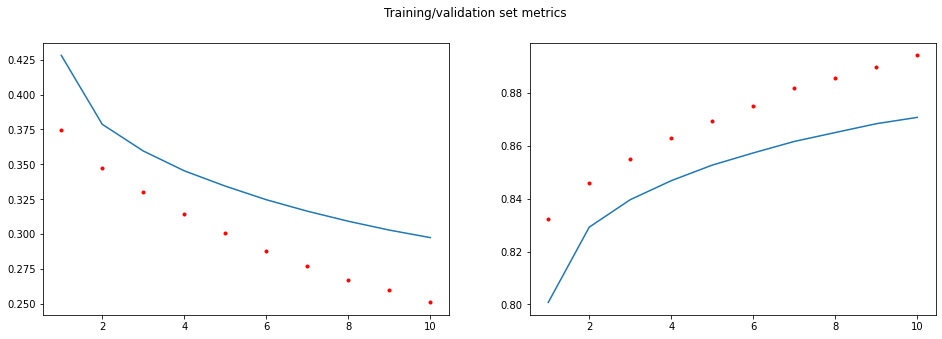

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Training/validation set metrics')

epoch_list = [i+1 for i in range(epochs)]

ax1.plot(epoch_list, loss_list)
ax1.plot(epoch_list, val_loss_list, 'r.')
ax2.plot(epoch_list, acc_list)
ax2.plot(epoch_list, val_acc_list, 'r.')

#### ROC Curve

No Skill: ROC AUC=0.500
RNN CLassifier: ROC AUC=0.962


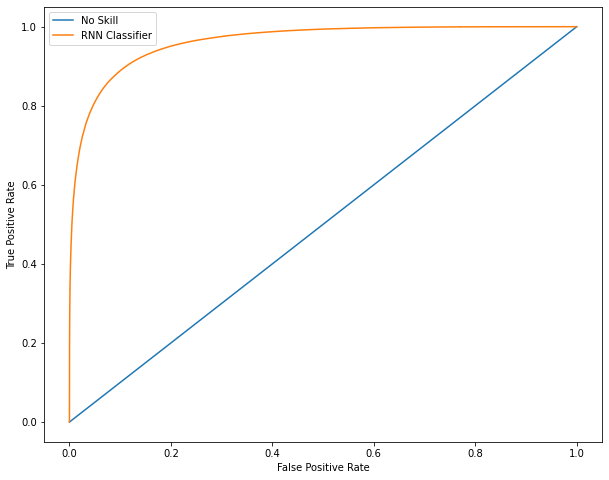

In [42]:
# get the true and predicted labels from the appropriate function
test_Y, predict_outs = get_labels(best_model, valid_iterator)

# calculate the fpr and tpr for all thresholds of the classification
probs = predict_outs.detach().numpy()

# # keep probabilities for the positive outcome only
lr_probs = probs
ns_probs = [0 for _ in range(len(test_Y))]

# calculate scores
ns_auc = roc_auc_score(test_Y, ns_probs)
lr_auc = roc_auc_score(test_Y, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RNN CLassifier: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_Y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_Y, lr_probs)

# plot the roc curve for the model
plt.figure(figsize=(10,8))
plt.plot(ns_fpr, ns_tpr, label='No Skill')
plt.plot(lr_fpr, lr_tpr, label='RNN Classifier')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Classification Report

In [43]:
print("Accuracy score: {}".format(round(accuracy_score(test_Y,predict_outs.round()),3)))
print(classification_report(test_Y,predict_outs.round()))

Accuracy score: 0.894
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89    576019
         1.0       0.89      0.90      0.89    575981

    accuracy                           0.89   1152000
   macro avg       0.89      0.89      0.89   1152000
weighted avg       0.89      0.89      0.89   1152000



#### Comparison to the Feed-Forward NN of the previous project

While comparing our best model to the one of the previous assignment, it is clear that this one predicts our dataset better, mainly due to the more complex computations. An other parameter that we observe, is the time that the model requires to be trained, as each epoch takes more than 2 minutes.

### Predicting the test dataset

Now that we've determined our best model, it is time to use it in order to predict the test dataset, and hold its accuracy and error

In [44]:
test_loss, test_acc = evaluate(best_model, test_iterator, loss)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.251 | Test Acc: 89.42%


We observe that the results are extremely good compared to our logistic regression models, as well as the Feed Forward Neural Network models. 

### Adding attention layer

For the bonus part of the assignment, we are going to add an attention layer to our best model, and compare the results.

Attention is a mechanism combined in the RNN allowing it to focus on certain parts of the input sequence when predicting a certain part of the output sequence, enabling easier learning and of higher quality. Combination of attention mechanisms enabled improved performance in many tasks making it an integral part of modern RNN networks.

In [45]:
cell_type = 'LSTM'
layers = 2
dropout = 0.2
learning_rate = 0.001
epochs = 10
hidden_neurons = 200
clipping_rate = (-100,100)
bidirectional = True
attention = True

In [46]:
best_model = Bidirectional_Stacked_RNN(input_shape, hidden_neurons, embedding_neurons, output_neurons, layers, cell_type, dropout, pad_idx, bidirectional, attention)

optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)

loss_list_att, acc_list_att, val_loss_list_att, val_acc_list_att = train_and_eval(best_model, train_iterator, valid_iterator, optimizer, loss, epochs, learning_rate, pad_idx, clipping_rate)

Began training for 2367302 trainable parameters


Epoch: 1/10  | Train Loss: 0.426 | Train Acc: 80.18% | Val. Loss: 0.376 |  Val. Acc: 83.15%
Epoch: 2/10  | Train Loss: 0.378 | Train Acc: 82.99% | Val. Loss: 0.348 |  Val. Acc: 84.55%
Epoch: 3/10  | Train Loss: 0.359 | Train Acc: 83.97% | Val. Loss: 0.333 |  Val. Acc: 85.25%
Epoch: 4/10  | Train Loss: 0.345 | Train Acc: 84.70% | Val. Loss: 0.316 |  Val. Acc: 86.21%
Epoch: 5/10  | Train Loss: 0.334 | Train Acc: 85.25% | Val. Loss: 0.301 |  Val. Acc: 86.98%
Epoch: 6/10  | Train Loss: 0.325 | Train Acc: 85.73% | Val. Loss: 0.289 |  Val. Acc: 87.58%
Epoch: 7/10  | Train Loss: 0.317 | Train Acc: 86.14% | Val. Loss: 0.278 |  Val. Acc: 88.13%
Epoch: 8/10  | Train Loss: 0.310 | Train Acc: 86.47% | Val. Loss: 0.270 |  Val. Acc: 88.57%
Epoch: 9/10  | Train Loss: 0.305 | Train Acc: 86.77% | Val. Loss: 0.262 |  Val. Acc: 88.95%
Epoch: 10/10  | Train Loss: 0.299 | Train Acc: 87.03% | Val. Loss: 0.254 |  Val. Acc: 89.34%


#### Comparison to the model without attention layer

Finally, let's plot the validation metrics comparing the 2 models, with and without attention, to observe any noticable difference

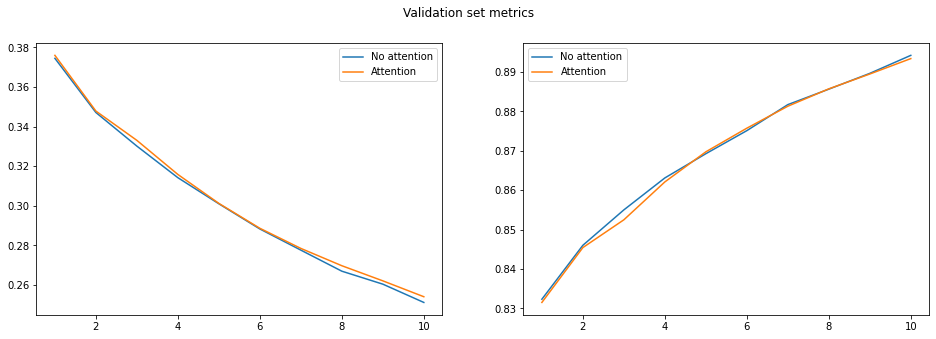

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Validation set metrics')

epoch_list = [i+1 for i in range(epochs)]

ax1.plot(epoch_list, val_loss_list, label='No attention')
ax1.plot(epoch_list, val_loss_list_att, label='Attention')
# show the legend
ax1.legend()
ax2.plot(epoch_list, val_acc_list,  label='No attention')
ax2.plot(epoch_list, val_acc_list_att, label='Attention')
ax2.legend()


As we can see, the results containing the attention layer are quite better, but without a big difference from the simple one.